# Generate and predict

_Akin Kazakci, MINES ParisTech, PSL University_

# Task definition

To be able to simulate future Covid-19 incidences based on our predictor, we need to be able to generate vectors of the input format of the said predictor. This vector has the following columns (we wil take away incidence variables that will be predicted by the predictor):

These variables come from the file 'incidences_merged.csv' (notebook 5) and are built with several scripts from the original Facebook data. There are 4 categories of variables:
- Covid-19 case information
- Movement dynamics inside a department
- Movement incoming to a department
- Centrality measures built using the whole movement data, augmented with population density information

In [346]:
import os
import json
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import pickle
from datetime import datetime
from datetime import timedelta
import matplotlib as mpl
mpl.style.use('seaborn')


# Get top models

In [473]:
report = pd.read_csv('data/reports/report2.csv', index_col=0)
report = report.sort_values('MAE')
report

,MAE,col_lag_end,col_lag_start,cols_to_lag,columns_to_keep,depth,features,incid_lag,incid_lag_end,incid_lag_start,model_input_cols,model_name,model_parameters
19,4.889375,14,21,NaN,"['incid_hosp', 'date', 'code_insee']",3,"Index(['incid_hosp(t-1)', 'incid_hosp(t-6)', '...",True,1,20,"Index(['incid_hosp(t-1)', 'incid_hosp(t-2)', '...",NaN,"{'estimator__base_score': 0.5, 'estimator__boo..."
23,4.911872,14,21,NaN,"['incid_hosp', 'date', 'code_insee']",3,"Index(['incid_hosp(t-6)', 'incid_hosp(t-8)', '...",True,1,24,"Index(['incid_hosp(t-1)', 'incid_hosp(t-2)', '...",NaN,"{'estimator__base_score': 0.5, 'estimator__boo..."
14,4.924134,14,21,NaN,"['incid_hosp', 'date', 'code_insee']",3,"Index(['incid_hosp(t-1)', 'incid_hosp(t-6)', '...",True,1,15,"Index(['incid_hosp(t-1)', 'incid_hosp(t-2)', '...",NaN,"{'estimator__base_score': 0.5, 'estimator__boo..."
21,4.935857,14,21,NaN,"['incid_hosp', 'date', 'code_insee']",3,"Index(['incid_hosp(t-7)', 'incid_hosp(t-8)', '...",True,1,22,"Index(['incid_hosp(t-1)', 'incid_hosp(t-2)', '...",NaN,"{'estimator__base_score': 0.5, 'estimator__boo..."
20,4.974490,14,21,NaN,"['incid_hosp', 'date', 'code_insee']",3,"Index(['incid_hosp(t-6)', 'incid_hosp(t-7)', '...",True,1,21,"Index(['incid_hosp(t-1)', 'incid_hosp(t-2)', '...",NaN,"{'estimator__base_score': 0.5, 'estimator__boo..."
13,4.991719,14,21,NaN,"['incid_hosp', 'date', 'code_insee']",3,"Index(['incid_hosp(t-1)', 'incid_hosp(t-6)', '...",True,1,14,"Index(['incid_hosp(t-1)', 'incid_hosp(t-2)', '...",NaN,"{'estimator__base_score': 0.5, 'estimator__boo..."
16,4.996209,14,21,NaN,"['incid_hosp', 'date', 'code_insee']",3,"Index(['incid_hosp(t-1)', 'incid_hosp(t-6)', '...",True,1,17,"Index(['incid_hosp(t-1)', 'incid_hosp(t-2)', '...",NaN,"{'estimator__base_score': 0.5, 'estimator__boo..."
18,5.008544,14,21,NaN,"['incid_hosp', 'date', 'code_insee']",3,"Index(['incid_hosp(t-1)', 'incid_hosp(t-6)', '...",True,1,19,"Index(['incid_hosp(t-1)', 'incid_hosp(t-2)', '...",NaN,"{'estimator__base_score': 0.5, 'estimator__boo..."
17,5.018025,14,21,NaN,"['incid_hosp', 'date', 'code_insee']",3,"Index(['incid_hosp(t-1)', 'incid_hosp(t-6)', '...",True,1,18,"Index(['incid_hosp(t-1)', 'incid_hosp(t-2)', '...",NaN,"{'estimator__base_score': 0.5, 'estimator__boo..."
15,5.051243,14,21,NaN,"['incid_hosp', 'date', 'code_insee']",3,"Index(['incid_hosp(t-1)', 'incid_hosp(t-6)', '...",True,1,16,"Index(['incid_hosp(t-1)', 'incid_hosp(t-2)', '...",NaN,"{'estimator__base_score': 0.5, 'estimator__boo..."


In [6]:
top_models = report[pd.notna(report.model_name)].head(10)
top_models

,MAE,col_lag_end,col_lag_start,cols_to_lag,columns_to_keep,depth,features,incid_lag,incid_lag_end,incid_lag_start,model_input_cols,model_name,model_parameters
0,5.272442,14,21,NaN,"['incid_hosp', 'date', 'code_insee']",3,"Index(['incid_hosp(t-1)', 'incid_hosp(t-2)'], ...",True,1,7,"Index(['incid_hosp(t-1)', 'incid_hosp(t-2)', '...",baseline_auto_incid_7_mob14-21.pickle,"{'estimator__base_score': 0.5, 'estimator__boo..."
123,6.290964,11,12,"['betweenness_centrality-16_0', 'closeness_cen...","['incid_hosp', 'betweenness_centrality-16_0', ...",3,"Index(['incid_hosp(t-1)', 'incid_hosp(t-5)', '...",True,1,7,"Index(['betweenness_centrality-16_0', 'closene...",auto_gr_incid_7_mob11-12.pickle,"{'estimator__base_score': 0.5, 'estimator__boo..."
116,6.291958,10,11,"['betweenness_centrality-16_0', 'closeness_cen...","['incid_hosp', 'betweenness_centrality-16_0', ...",3,"Index(['incid_hosp(t-1)', 'incid_hosp(t-2)', '...",True,1,7,"Index(['betweenness_centrality-16_0', 'closene...",auto_gr_incid_7_mob10-11.pickle,"{'estimator__base_score': 0.5, 'estimator__boo..."
125,6.437941,9,12,"['betweenness_centrality-16_0', 'closeness_cen...","['incid_hosp', 'betweenness_centrality-16_0', ...",3,"Index(['incid_hosp(t-1)', 'incid_hosp(t-2)', '...",True,1,7,"Index(['betweenness_centrality-16_0', 'closene...",auto_gr_incid_7_mob9-12.pickle,"{'estimator__base_score': 0.5, 'estimator__boo..."
117,6.470235,9,11,"['betweenness_centrality-16_0', 'closeness_cen...","['incid_hosp', 'betweenness_centrality-16_0', ...",3,"Index(['incid_hosp(t-1)', 'incid_hosp(t-2)', '...",True,1,7,"Index(['betweenness_centrality-16_0', 'closene...",auto_gr_incid_7_mob9-11.pickle,"{'estimator__base_score': 0.5, 'estimator__boo..."
124,6.488859,10,12,"['betweenness_centrality-16_0', 'closeness_cen...","['incid_hosp', 'betweenness_centrality-16_0', ...",3,"Index(['incid_hosp(t-1)', 'incid_hosp(t-2)', '...",True,1,7,"Index(['betweenness_centrality-16_0', 'closene...",auto_gr_incid_7_mob10-12.pickle,"{'estimator__base_score': 0.5, 'estimator__boo..."
118,6.535391,8,11,"['betweenness_centrality-16_0', 'closeness_cen...","['incid_hosp', 'betweenness_centrality-16_0', ...",3,"Index(['closeness_centrality-0_8', 'incid_hosp...",True,1,7,"Index(['betweenness_centrality-16_0', 'closene...",auto_gr_incid_7_mob8-11.pickle,"{'estimator__base_score': 0.5, 'estimator__boo..."
140,6.566873,10,14,"['betweenness_centrality-16_0', 'closeness_cen...","['incid_hosp', 'betweenness_centrality-16_0', ...",3,"Index(['closeness_centrality-0_8', 'closeness_...",True,1,7,"Index(['betweenness_centrality-16_0', 'closene...",auto_gr_incid_7_mob10-14.pickle,"{'estimator__base_score': 0.5, 'estimator__boo..."
131,6.577300,11,13,"['betweenness_centrality-16_0', 'closeness_cen...","['incid_hosp', 'betweenness_centrality-16_0', ...",3,"Index(['closeness_centrality-0_8', 'incid_hosp...",True,1,7,"Index(['betweenness_centrality-16_0', 'closene...",auto_gr_incid_7_mob11-13.pickle,"{'estimator__base_score': 0.5, 'estimator__boo..."
141,6.579665,9,14,"['betweenness_centrality-16_0', 'closeness_cen...","['incid_hosp', 'betweenness_centrality-16_0', ...",3,"Index(['closeness_centrality-0_8', 'closeness_...",True,1,7,"Index(['betweenness_centrality-16_0', 'closene...",auto_gr_incid_7_mob9-14.pickle,"{'estimator__base_score': 0.5, 'estimator__boo..."


In [7]:
def get_model(filename):
    #load model
    model = pickle.load(open(os.path.join('models/',filename), 'rb'))
    return model

In [8]:
def get_model_data(filename):
    #load  data
    data =  pd.read_csv(os.path.join('data/expe_data/','data_for_'+filename+'.csv'), index_col =0)
    return data

In [470]:
def get_model_params(filename):
    report = pd.read_csv('data/reports/report4.csv', index_col=0)
    report = report.sort_values('MAE')
    report
    
    params = report[report.model_name == filename]
    cols_to_lag = list(params['cols_to_lag'].reset_index().drop('index',axis = 1).iloc[0].values)#[0]
    incid_lag = bool(params['incid_lag'].reset_index().drop('index',axis = 1).iloc[0].values)
    return cols_to_lag, incid_lag

In [475]:
#d,f = get_model_params('auto_gr_incid_7_mob11-12.pickle')
#f

In [445]:
def minus_plus():
    return 1 if random.random() < 0.5 else -1

In [446]:
def draw(data, columns, strategy = 'maxi'):
   
    if strategy == 'maxi':
        #return  data.groupby('code_insee', as_index=False).max(axis = 1)
        return  data.groupby('code_insee', as_index=False).quantile(0.9+0.1*np.random.rand(), interpolation = 'linear')
  
    if strategy == 'mini':
        return data.groupby('code_insee', as_index=False).quantile(0.1+0.1*np.random.rand(), interpolation = 'linear')
    
    if strategy == 'average': 
        return data.groupby('code_insee', as_index=False).quantile(0.5+0.1*minus_plus(), interpolation = 'linear')

The drawing should be done at the department level.

In [476]:
number_of_steps = 15 # 15 days ahead

def simulate(number_of_steps, model_name, strategy =  'maxi'):
    #load model
    model = get_model(model_name)
    
    #load data
    data = get_model_data(model_name)
    cols = data.columns
    #print(data.shape)
    
    # get model params, to be able to generate synthetic data
    cols_to_lag, incid_lag = get_model_params(model_name)
    # the following line should be better handled (if legth diff will cause error)
    incid_cols = ['incid_hosp','incid_hosp(t-1)', 'incid_hosp(t-2)', 'incid_hosp(t-3)', 'incid_hosp(t-4)', 
                  'incid_hosp(t-5)', 'incid_hosp(t-6)', 'incid_hosp(t-7)']
    cols = [x for x in data.columns if x not in incid_cols]  
   
    # store results
    results = []
    
    #get last available date
    data.sort_values('date', ascending = True, inplace= True)
    last_day = pd.to_datetime(data.date.iloc[-1])
    data.code_insee = data.code_insee.apply(lambda x: str(x))
    # fill data's prediction column from split_date to last day [data.date > '2020-04-20']
    
    print(data.columns)
    for i in range(number_of_steps+1):
        # get values from past distribution, here simply min/max/mean
        df  = draw(data[cols], strategy)
        
        next_day = pd.to_datetime(last_day) + timedelta(days=1)
        next_day = next_day.strftime("%Y-%m-%d")
        
        #df[~df.date] = df.astype(float)
        df['date'] = next_day
        
        # WHAT IF NOT INCID?? if incid_lag:
        df[incid_cols] = data[data.date == last_day][incid_cols].shift(1, axis = 1) 
       # print(df.columns)
        df = df[data.columns.drop('code_insee')]
       
        #predict incid_hosp for next day based on loaded model
        X_test = df.drop(['date','incid_hosp'], axis =1)
        prediction = model.predict(X_test)
        
        df['predictions'] = prediction
        df['incid_hosp'] = prediction
        
        last_day = next_day
        results.append(df)
    
    # assign past predictions _after_ the above loop
    X_test = data.drop(['date','code_insee', 'incid_hosp'], axis =1)
    prediction = model.predict(X_test)   
    data['predictions'] = prediction
    
    for df in results:
        #print('DATA', data.columns)
        #print('DF',df.columns)
        data = pd.concat([
            data,
            df
        ], axis=0, sort=True)
        
    
    #plot results
    return data[['date','code_insee','predictions','incid_hosp']]

In [477]:
#model_name = 'auto_gr_incid_7_mob11-12.pickle'
model_name = 'obj_count_auto_mov_gr_incid_7_mob9-12.pickle'

In [478]:
dut = simulate(30, model_name)

Index(['incid_hosp', 'date', 'code_insee', 'incid_hosp(t-1)',
       'incid_hosp(t-2)', 'incid_hosp(t-3)', 'incid_hosp(t-4)',
       'incid_hosp(t-5)', 'incid_hosp(t-6)', 'incid_hosp(t-7)',
       'betweenness_centrality-16_0(t-9)', 'betweenness_centrality-16_0(t-10)',
       'betweenness_centrality-16_0(t-11)',
       'betweenness_centrality-16_0(t-12)', 'closeness_centrality-16_0(t-9)',
       'closeness_centrality-16_0(t-10)', 'closeness_centrality-16_0(t-11)',
       'closeness_centrality-16_0(t-12)', 'degree_centrality-16_0(t-9)',
       'degree_centrality-16_0(t-10)', 'degree_centrality-16_0(t-11)',
       'degree_centrality-16_0(t-12)', 'eigenvector_centrality-16_0(t-9)',
       'eigenvector_centrality-16_0(t-10)',
       'eigenvector_centrality-16_0(t-11)',
       'eigenvector_centrality-16_0(t-12)', 'betweenness_centrality-0_8(t-9)',
       'betweenness_centrality-0_8(t-10)', 'betweenness_centrality-0_8(t-11)',
       'betweenness_centrality-0_8(t-12)', 'closeness_centrality-0

In [484]:
dut.head()

,date,code_insee,predictions,incid_hosp
1989,2020-04-07,93,209.839218,212.0
1940,2020-04-07,82,2.060048,0.0
1923,2020-04-07,61,10.914437,14.0
1922,2020-04-07,42,37.135078,32.0
1919,2020-04-07,75,242.884766,238.0


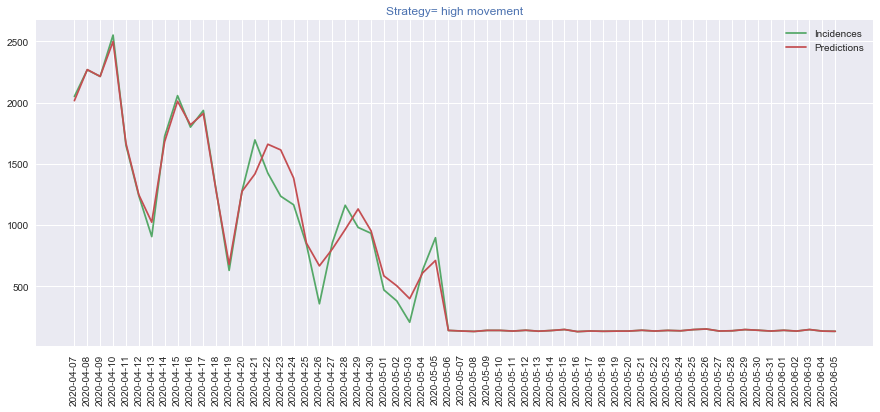

In [480]:
dut_sum = dut.groupby('date', as_index = False).sum()

fig, ax = plt.subplots( figsize=(15,6) )


ax.set_title('Strategy= high movement'.format('seaborn'), color='C0')

ax.plot(dut_sum.date, dut_sum['incid_hosp'], 'C1', label='Incidences')
ax.plot(dut_sum.date, dut_sum['predictions'], 'C2', label='Predictions')
ax.legend()
plt.xticks(dut_sum.date, dut_sum.date, rotation='vertical')


plt.show()

Index(['incid_hosp', 'date', 'code_insee', 'incid_hosp(t-1)',
       'incid_hosp(t-2)', 'incid_hosp(t-3)', 'incid_hosp(t-4)',
       'incid_hosp(t-5)', 'incid_hosp(t-6)', 'incid_hosp(t-7)',
       'betweenness_centrality-16_0(t-9)', 'betweenness_centrality-16_0(t-10)',
       'betweenness_centrality-16_0(t-11)',
       'betweenness_centrality-16_0(t-12)', 'closeness_centrality-16_0(t-9)',
       'closeness_centrality-16_0(t-10)', 'closeness_centrality-16_0(t-11)',
       'closeness_centrality-16_0(t-12)', 'degree_centrality-16_0(t-9)',
       'degree_centrality-16_0(t-10)', 'degree_centrality-16_0(t-11)',
       'degree_centrality-16_0(t-12)', 'eigenvector_centrality-16_0(t-9)',
       'eigenvector_centrality-16_0(t-10)',
       'eigenvector_centrality-16_0(t-11)',
       'eigenvector_centrality-16_0(t-12)', 'betweenness_centrality-0_8(t-9)',
       'betweenness_centrality-0_8(t-10)', 'betweenness_centrality-0_8(t-11)',
       'betweenness_centrality-0_8(t-12)', 'closeness_centrality-0

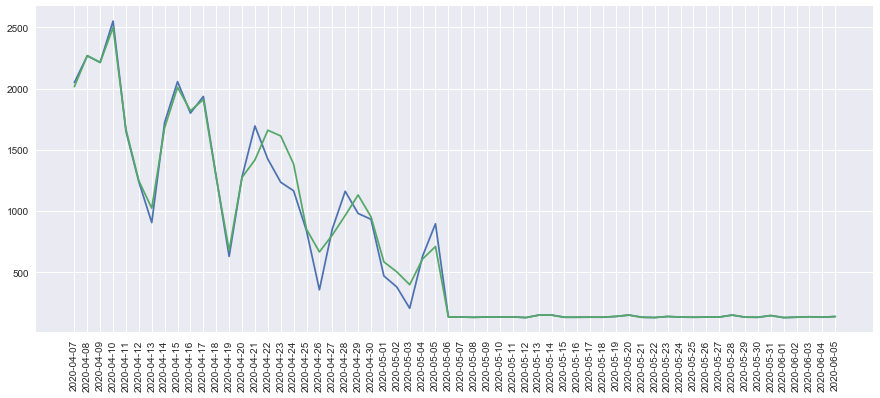

In [481]:
dut = simulate(30, model_name, 'mini')
dut_sum = dut.groupby('date', as_index = False).sum()

fig = plt.figure( figsize=(15,6) )
plt.plot(dut_sum.date, dut_sum[['incid_hosp','predictions']])
plt.xticks(dut_sum.date, dut_sum.date, rotation='vertical')
plt.show()

Index(['incid_hosp', 'date', 'code_insee', 'incid_hosp(t-1)',
       'incid_hosp(t-2)', 'incid_hosp(t-3)', 'incid_hosp(t-4)',
       'incid_hosp(t-5)', 'incid_hosp(t-6)', 'incid_hosp(t-7)',
       'betweenness_centrality-16_0(t-9)', 'betweenness_centrality-16_0(t-10)',
       'betweenness_centrality-16_0(t-11)',
       'betweenness_centrality-16_0(t-12)', 'closeness_centrality-16_0(t-9)',
       'closeness_centrality-16_0(t-10)', 'closeness_centrality-16_0(t-11)',
       'closeness_centrality-16_0(t-12)', 'degree_centrality-16_0(t-9)',
       'degree_centrality-16_0(t-10)', 'degree_centrality-16_0(t-11)',
       'degree_centrality-16_0(t-12)', 'eigenvector_centrality-16_0(t-9)',
       'eigenvector_centrality-16_0(t-10)',
       'eigenvector_centrality-16_0(t-11)',
       'eigenvector_centrality-16_0(t-12)', 'betweenness_centrality-0_8(t-9)',
       'betweenness_centrality-0_8(t-10)', 'betweenness_centrality-0_8(t-11)',
       'betweenness_centrality-0_8(t-12)', 'closeness_centrality-0

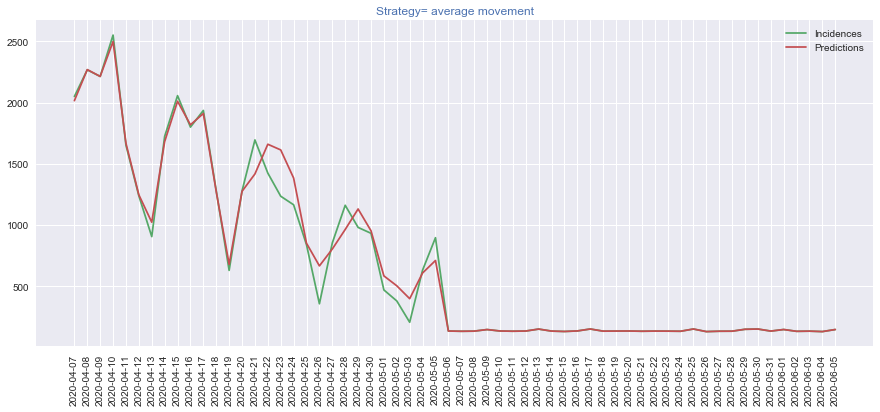

In [482]:
dut = simulate(30, model_name, 'average')
dut_sum = dut.groupby('date', as_index = False).sum()

fig, ax = plt.subplots( figsize=(15,6) )

ax.set_title('Strategy= average movement'.format('seaborn'), color='C0')

ax.plot(dut_sum.date, dut_sum['incid_hosp'], 'C1', label='Incidences')
ax.plot(dut_sum.date, dut_sum['predictions'], 'C2', label='Predictions')
ax.legend()

plt.xticks(dut_sum.date, dut_sum.date, rotation='vertical')
plt.show()